In [5]:
# following is a gpu mig bug fix
import os
import subprocess
if "MIG" in subprocess.check_output(["nvidia-smi", "-L"], text=True):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [52]:
import torch
from torch.utils.data import Dataset
import h5py
from pathlib import Path
from dataloaders.utils import spatial_resample
import numpy as np

class AmiraReaderFromAM:
    def __init__(self, filepaths, resample_shape=128, resample_mode='fourier', timesample=5):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        self.name = None
        self.vel_scale = None
        self.dt = timesample
        
        for filepath in filepaths:
            #print(filepath)
            data = torch.from_numpy(self.read_amira_binary_mesh(filepath).copy())
            data = data.permute(0,3,1,2)
            data = spatial_resample(data, self.resample_shape, self.resample_mode)
            self.data_list.append(data)
            self.traj_list.append(torch.tensor(1))
            if self.ts is None:
                self.ts = data.shape[0]
        
        self.data = torch.stack(self.data_list, dim=0)
        #print(self.data.shape)
        self.traj = sum(self.traj_list)

    def read_amira_binary_mesh(self, filename):
        with open(filename, 'rb') as f:
            raw_data = f.read()
        # first occurrence of "@1"
        first_marker_idx = raw_data.find(b'@1')
        if first_marker_idx == -1:
            raise ValueError("Could not find binary data section in Amira file.")
        # second occurrence of "@1"
        second_marker_idx = raw_data.find(b'@1', first_marker_idx + 2)
        if second_marker_idx == -1:
            raise ValueError("Could not find second binary data section in Amira file.")
        data_start = second_marker_idx + 4  # Skip '@1\n'
        binary_data = raw_data[data_start:]
        lattice_shape = (1001, 512, 512, 2)
        float_data = np.frombuffer(binary_data, dtype=np.float32)
        float_data = float_data.reshape(lattice_shape)
        return float_data
        
    def get_single_traj(self, idx):
        full = self.data[idx][::self.dt]
        return full
    
    def normalize_velocity(self, vel_scale):
        self.data = self.data / vel_scale
        self.vel_scale = vel_scale

    def absmax_vel(self):
        return self.data.abs().max()

class AmiraDatasetFromAM(Dataset):
    def __init__(self, reader: AmiraReaderFromAM, temporal_bundling = 1, forward_steps = 1):
        self.reader = reader
        self.traj = reader.traj
        self.dt = reader.dt
        self.ts = reader.ts
        self.tb = temporal_bundling
        self.fs = forward_steps
        
    def __len__(self):
        return self.reader.traj * (self.reader.ts - self.reader.dt * self.tb)

    def __getitem__(self, idx):
        traj_idx = idx // (self.reader.ts - self.reader.dt)
        ts_idx = idx % (self.reader.ts - self.reader.dt)
        
        front = self.reader.data[traj_idx][ts_idx : ts_idx + self.reader.dt * self.tb : self.reader.dt]
        label = self.reader.data[traj_idx][ts_idx + self.fs * self.reader.dt * self.tb : ts_idx + (self.fs + 1) * self.reader.dt * self.tb : self.reader.dt]
        return front, label


In [53]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
test = np.array([1,2,3,4,5,6,7,8,9])
test[0:5:2]

CUDA available: True
CUDA device count: 1


array([1, 3, 5])

In [54]:
reader = AmiraReaderFromAM(['../datasets/prjs1359/AmiraSet/6080.am'], resample_shape=128, resample_mode='fourier')

In [55]:
tb = 10
dataset = AmiraDatasetFromAM(reader, temporal_bundling=tb, forward_steps=1)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)
for i, (front, label) in enumerate(loader):
    print(f"Batch {i}:")
    print("Front shape:", front.shape)
    print("Label shape:", label.shape)
    break


Batch 0:
Front shape: torch.Size([5, 10, 2, 128, 128])
Label shape: torch.Size([5, 10, 2, 128, 128])


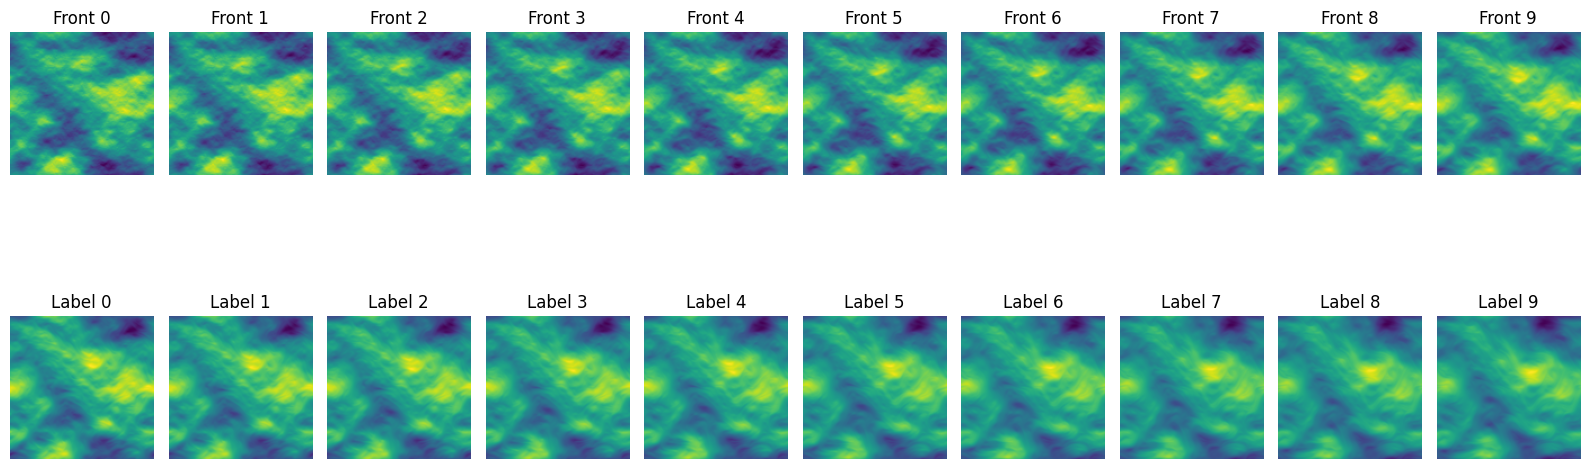

In [56]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, tb, figsize=(16, 7))
for i in range(tb):
    ax[0,i].imshow(front[0, i, 0, :, :].cpu().numpy())
    ax[1,i].imshow(label[0, i, 0, :, :].cpu().numpy())
    ax[0,i].set_title(f"Front {i}")
    ax[0,i].axis('off')
    ax[1,i].set_title(f"Label {i}")
    ax[1,i].axis('off')
plt.tight_layout()
plt.show()

In [15]:
import torch
import torch.nn.functional as F
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np
import math
from modelComp.utils import ConvNeXtBlock, ResNetBlock, SwiGLU, MLP


def window_partition(x, window_size):

    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):

    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x



class LinearEmbedding(nn.Module):

    def __init__(self, emb_dim = 96, data_dim = (1,5,4,128,128), patch_size = (8,8), hiddenout_dim = 256, act=nn.GELU):
        super().__init__()
        
        self.B, self.T, self.C, self.H, self.W = data_dim
        self.emb_dim = emb_dim
        self.pH, self.pW = patch_size
        self.hiddenout_dim = hiddenout_dim
        self.patch_grid_res = (self.H // self.pH, self.W // self.pW)
        

        assert self.H % self.pH == 0 and self.W % self.pW == 0, "spatial input dim must be divisible by patch_size"
        assert self.H == self.W, "must be square"
        

        self.patchify = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.unpatchify = nn.Fold(output_size=(self.H, self.W), kernel_size=patch_size, stride=patch_size)
        self.pre_proj = nn.Sequential(
            nn.Linear(self.C * self.pH * self.pW, self.emb_dim * 2 if act == SwiGLU else self.emb_dim),
            act(),
            nn.Linear(self.emb_dim, self.emb_dim),
        )

        self.post_proj = nn.Sequential(
            nn.Linear(self.emb_dim, self.hiddenout_dim* 2 if act == SwiGLU else self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.hiddenout_dim* 2 if act == SwiGLU else self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.C * self.pH * self.pW),
        )

    #def get_pos_embeddings(self, t_len):
    #    return (self.time_embed[:, :t_len] + self.patch_position_embeddings).view(1, -1, self.emb_dim)  # (1, t*p*p, d)

    def encode(self, x, proj=True):

        B, T, C, H, W = x.shape
        #print(1, x.shape)
        #x = rearrange(x, "b t c h w -> (b t) c h w") #might change to .permute
        #print(2, x.shape)
        x = rearrange(x, 'b t c h w -> (b t) c h w')
        #print('before patchify', x.shape)
        x = self.patchify(x)  
        #print('after patchify', x.shape)
        #print(3, x.shape)
        x = rearrange(x, '(b t) d n -> b t n d', b=B, t=T)
        #print('after rearrange', x.shape)
        #x = rearrange(x, "(b t) d pp -> b (t pp) d", b=B) # should think about this
        #x = rearrange(x, "b d pp -> b pp d")
        #print(4, x.shape)

        # TODO: add Positional Encoding
        if proj:
            #print(5, x.shape)
            return self.pre_proj(x)#.transpose(1, 2)
        else:
            return x#.transpose(1, 2)

    def decode(self, x, proj=True):
        if proj:
            x = self.post_proj(x)  

        B, T, N, D = x.shape
        #x = rearrange(x, "b (t pp) d -> (b t) d pp", pp=self.patch_grid_res[0]*self.patch_grid_res[1]) #might change to .permute
        x = rearrange(x, 'b t n d -> (b t) d n')
        #print('before unpatchify decode', x.shape)
        x = self.unpatchify(x)  
        #print(x.shape)
        #x = rearrange(x, "(b t) c h w -> b t c h w", b=B)
        x = rearrange(x, '(b t) c h w -> b t c h w', t=T)
        #print('end decoder: ', x.shape)
        return x

class SpatiotemporalPositionalEncoding(nn.Module):
    def __init__(self, emb_dim, height, width, timesteps):
        super().__init__()
        self.emb_dim = emb_dim
        self.H = height
        self.W = width
        self.T = timesteps

        assert emb_dim % 2 == 0, "emb_dim must be divisible by 2"
        self.row_embed = nn.Parameter(torch.randn(1, self.H, 1, emb_dim // 2))
        self.col_embed = nn.Parameter(torch.randn(1, 1, self.W, emb_dim // 2))
        self.time_embed = nn.Parameter(torch.randn(1, self.T, 1, emb_dim))  # full D for time

    def forward(self, x):
        # x: (B, T, N, D)
        B, T, N, D = x.shape
        H, W = self.H, self.W
        assert N == H * W, f"Expected N = H*W = {H}x{W}, got {N}"

        # Spatial embeddings: (1, H, W, D)
        spatial = torch.cat([
            self.row_embed.expand(-1, H, W, -1),  # (1, H, W, D//2)
            self.col_embed.expand(-1, H, W, -1)   # (1, H, W, D//2)
        ], dim=-1).view(1, 1, N, D)  # -> (1, 1, N, D)

        # Temporal embedding: (1, T, 1, D)
        time = self.time_embed  # already (1, T, 1, D)

        pos = spatial + time  # broadcasts over (B, T, N, D)

        return x + pos
 
class PatchMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(4*emb_dim, 2*emb_dim)

    def forward(self, x):
        B, T, L, C = x.shape
        H = W = int(np.sqrt(L)/2)
        x = rearrange(x, 'b t (h s1 w s2) c -> b t (h w) (s1 s2 c)', s1=2, s2=2, h=H, w=W) #might change to .permute
        x = self.linear(x)
        return x

class PatchUnMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(emb_dim, 2*emb_dim)
    
    def forward(self, x):
        B, T, L, C = x.shape
        H = W = int(np.sqrt(L))
        #print(x.shape, H, W)
        x = self.linear(x)
        #print(x.shape)
        x = rearrange(x, 'b t (h w) (s1 s2 c) -> b t (h s1 w s2) c', s1=2, s2=2, h=H, w=W) #might change to .permute
        return x


class WindowAttention(nn.Module):

    def __init__(self, emb_dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.,
    use_flex_attn=True, act=nn.ReLU):

        super().__init__()
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv_bias = qkv_bias
        self.use_flex_attn = use_flex_attn # original from logits scale BCAT?

        assert emb_dim % num_heads == 0, "embedding dimension must be divisible by number of heads"
        

        if self.use_flex_attn: 
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)
            #self.register_parameter("flex_attn", nn.Parameter(self.flex_attn))

        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(nn.Linear(2, 512, bias=True),
                                     act(),
                                     nn.Linear(512, num_heads, bias=False))

        # get relative_coords_table
        relative_coords_h = torch.arange(-(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32)
        relative_coords_w = torch.arange(-(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32)
        relative_coords_table = torch.stack(
            torch.meshgrid([relative_coords_h,
                            relative_coords_w])).permute(1, 2, 0).contiguous().unsqueeze(0)  
        
        relative_coords_table[:, :, :, 0] /= (self.window_size[0] - 1)
        relative_coords_table[:, :, :, 1] /= (self.window_size[1] - 1)
        relative_coords_table *= 8  # normalize to -8, 8 TODO: understand why
        relative_coords_table = torch.sign(relative_coords_table) * torch.log2(
            torch.abs(relative_coords_table) + 1.0) / np.log2(8)

        self.register_buffer("relative_coords_table", relative_coords_table)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) 
        coords_flatten = torch.flatten(coords, 1)  
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  
        relative_coords[:, :, 0] += self.window_size[0] - 1  
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(emb_dim))
            self.v_bias = nn.Parameter(torch.zeros(emb_dim))
            # TODO: understand why not key bias
        else:
            self.q_bias = None
            self.v_bias = None
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_out = nn.Linear(emb_dim, emb_dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):

        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        #print(x.shape, self.qkv.weight.shape, qkv_bias.shape)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        #print('test')
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # cosine attention
        attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
        if self.use_flex_attn:
            flex_attn = torch.clamp(self.flex_attn, max=torch.log(torch.tensor(1. / 0.01, device=x.device))).exp()
            attn = attn * flex_attn

        relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
        relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1) 
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj_out(x)
        x = self.proj_drop(x)
        return x

    
class SpatialSwinBlock(nn.Module): #change name to something else

    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size=4, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True, 
                 act=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        #self.use_proj_in = use_proj_in
        #print('shift_size', self.shift_size)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(emb_dim)
        #print('test')
        self.attn = WindowAttention(
            emb_dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, use_flex_attn=use_flex_attn,
            act=nn.ReLU) # act is for relative position bias mlp so maybe not use swiglu/gelu
        #print('test')
        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim, act=act, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA (from original swin paper source code)
            H, W = self.patch_grid_res
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            #print('test')
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.patch_grid_res
        B, T, L, C = x.shape
        assert L == H * W, f"Expected L = H*W = {H}x{W}, but got L = {L}"

        shortcut = x
        x = x.view(B * T, H, W, C)  # Combine B and T for window partitioning

        # Apply cyclic shift if needed
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

        # Partition into windows and compute attention
        x_windows = window_partition(x, self.window_size)  # (num_windows*B*T, ws, ws, C)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # (num_windows*B*T, ws*ws, C)

        # Merge windows back
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        x = window_reverse(attn_windows, self.window_size, H, W)  # (B*T, H, W, C)

        # Reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))

        # Reshape back to (B, T, H*W, C)
        x = x.view(B, T, H * W, C)

        # Residual + MLP
        x = shortcut + self.norm1(x)
        x = x + self.norm2(self.mlp(x))

        return x

class TemporalBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, max_timesteps=5, mlp_ratio=4.0,
                 qkv_bias=True, drop=0.0, attn_drop=0.0, use_flex_attn=True,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.max_timesteps = max_timesteps

        self.norm1 = norm_layer(emb_dim)
        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.proj_drop = nn.Dropout(drop)

        self.use_flex_attn = use_flex_attn
        if self.use_flex_attn:
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)

        # Continuous relative positional bias (not trainable)
        relative_positions = torch.arange(-max_timesteps + 1, max_timesteps, dtype=torch.float32)
        relative_positions /= (max_timesteps - 1)
        bias_values = torch.sign(relative_positions) * torch.log2(torch.abs(relative_positions) + 1.0) / np.log2(2)
        bias_table = bias_values.unsqueeze(1).repeat(1, num_heads)
        self.register_buffer("relative_position_bias_table", bias_table)

        coords = torch.arange(max_timesteps)
        relative_coords = coords[None, :] - coords[:, None]
        relative_coords += max_timesteps - 1
        self.register_buffer("relative_position_index", relative_coords)

        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim,
                       act=act_layer, drop=drop)

    def forward(self, x):
        # x: (B, T, E, C)
        B, T, E, C = x.shape
        assert T <= self.max_timesteps, f"Input timesteps {T} exceed max_timesteps {self.max_timesteps}"

        # ============ Attention Block ============
        x_ = x.permute(0, 2, 1, 3).contiguous()  # (B, E, T, C)
        x_ = self.norm1(x_).reshape(B * E, T, C)

        qkv = self.qkv(x_).reshape(B * E, T, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.unbind(dim=2)  # (B*E, T, num_heads, head_dim)
        q = q.transpose(1, 2)  # (B*E, heads, T, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) / (C // self.num_heads) ** 0.5
        if self.use_flex_attn:
            max_log = torch.log(torch.tensor(1. / 0.01, device=attn.device))
            flex_attn = torch.clamp(self.flex_attn, max=max_log).exp()
            attn = attn * flex_attn

        bias = self.relative_position_bias_table[self.relative_position_index[:T, :T].reshape(-1)]
        bias = bias.view(T, T, self.num_heads).permute(2, 0, 1)  # (heads, T, T)
        attn = attn + bias.unsqueeze(0)

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        attn_out = (attn @ v).transpose(1, 2).reshape(B * E, T, C)
        attn_out = self.proj(attn_out)
        attn_out = self.proj_drop(attn_out)

        x_ = x_ + attn_out  # Residual 1
        x_ = x_.reshape(B, E, T, C).permute(0, 2, 1, 3).contiguous()  # (B, T, E, C)

        x_norm = self.norm2(x_)
        x = x_ + self.mlp(x_norm)  # Residual 2

        return x
    
class SwinStage(nn.Module): # change name since stage also includes patch merge formally
    
    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True,
                 act=nn.GELU, norm_layer=nn.LayerNorm):

        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res

        # build blocks
        self.blocks = nn.ModuleList([
            SpatialSwinBlock(emb_dim=emb_dim, patch_grid_res=patch_grid_res,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, 
                                 drop=drop,
                                 attn_drop=attn_drop,
                                 use_flex_attn=use_flex_attn,
                                 act=act,
                                 norm_layer=norm_layer
                                 )
            for i in range(2)])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x

class SwinUnet(nn.Module):
    def __init__(self, emb_dim, data_dim, patch_size, hiddenout_dim, depth, 
                 stage_depths, num_heads, window_size=8, mlp_ratio=4., 
                 qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True, norm_layer=nn.LayerNorm,
                 act=nn.GELU, skip_connect=ConvNeXtBlock, gradient_flowthrough=[True, False, False]):
        super().__init__()

        # assert that every element in stage_depths is divisible by 3 except for the middle element
        assert all(stage_depths[i] % 3 == 0 for i in range(len(stage_depths)) if i != depth), "stage depth must be divisible by 3 at non-middle elements"
        assert stage_depths[depth] % 2 == 0, "stage depth must be divisible by 2 at middle element"
        self.embedding = LinearEmbedding(emb_dim, data_dim, patch_size, hiddenout_dim, act)
        self.pos_encoding = SpatiotemporalPositionalEncoding(emb_dim, data_dim[3] // patch_size[0], data_dim[4] // patch_size[1], data_dim[1])
        #print(data_dim[2] // patch_size[0], data_dim[2] // patch_size[0], data_dim[1])
        self.blockDown = [nn.ModuleList() for i in range(depth)]
        self.blockMiddle = nn.ModuleList()
        self.blockUp = [nn.ModuleList() for i in range(depth)]
        self.patchMerges = nn.ModuleList()
        self.patchUnmerges = nn.ModuleList()
        self.skip_connects = nn.ModuleList()
        # TODO: implement act 

        self.depth = depth
        self.middleblocklen = stage_depths[depth]
        self.gradient_flowthrough = gradient_flowthrough
        self.skip_connect = skip_connect

        for i in range(depth):
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            for j in range(stage_depths[i]):
                #print(j)
                if j % 3 == 0:
                    self.blockDown[i].append(
                        SwinStage(
                            emb_dim * 2**i, 
                            patch_grid_res=patch_grid_res, 
                            num_heads=num_heads[i], 
                            window_size=window_size, 
                            mlp_ratio = mlp_ratio, 
                            qkv_bias = qkv_bias, 
                            drop=drop,
                            attn_drop = attn_drop,
                            use_flex_attn = use_flex_attn, 
                            act=act, 
                            norm_layer=norm_layer
                        )
                    )
                    j += 1
                elif j % 3 == 2:
                    self.blockDown[i].append(
                        TemporalBlock(
                            emb_dim=emb_dim * 2**i,
                            num_heads=num_heads[i],
                            max_timesteps=data_dim[1],
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act_layer=act,
                            norm_layer=norm_layer
                        )
                    )

            self.patchMerges.append(PatchMerge(emb_dim * 2**i))


        patch_grid_res = (data_dim[3] // (patch_size[0] * 2**depth), data_dim[4] // (patch_size[1] * 2**depth))
        full_window_size = data_dim[3] // (patch_size[0] * 2**depth)
        #print('full_window_size', full_window_size)
        for i in range(stage_depths[depth]):
            if i % 2 == 0:

                self.blockMiddle.append(
                    SpatialSwinBlock(
                        emb_dim * 2**depth,
                        patch_grid_res=patch_grid_res,
                        num_heads=num_heads[depth],
                        window_size = full_window_size,
                        shift_size=0,
                        mlp_ratio=mlp_ratio,
                        qkv_bias=qkv_bias,
                        drop=0.,
                        attn_drop=0.,
                        use_flex_attn=use_flex_attn,
                        act=act,
                        norm_layer=norm_layer
                    )
                )
            if i % 2 == 1:
                self.blockMiddle.append(
                    TemporalBlock(
                        emb_dim=emb_dim * 2**depth,
                        num_heads=num_heads[depth],
                        max_timesteps=data_dim[1],
                        mlp_ratio=mlp_ratio,
                        qkv_bias=qkv_bias,
                        drop=drop,
                        attn_drop=attn_drop,
                        use_flex_attn=use_flex_attn,
                        act_layer=act,
                        norm_layer=norm_layer
                    )
                )

        for i in reversed(range(depth)):
            #print(i)
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            for j in range(stage_depths[depth + i + 1]):
                #print(depth + i, j)
                #print(i, emb_dim * 2**i)
                if j % 3 == 0:
                    self.blockUp[depth - i - 1].append(
                        SwinStage(
                            emb_dim * 2**i, 
                            patch_grid_res=patch_grid_res, 
                            num_heads=num_heads[2*depth - i], 
                            window_size=window_size, 
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act=act,
                            norm_layer=norm_layer
                        )
                    )
                    j += 1
                elif j % 3 == 2:
                    self.blockUp[depth - i - 1].append(
                        TemporalBlock(
                            emb_dim=emb_dim * 2**i,
                            num_heads=num_heads[2*depth - i],
                            max_timesteps=data_dim[1],
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act_layer=act,
                            norm_layer=norm_layer
                        )
                    )
                    
            self.patchUnmerges.append(PatchUnMerge(emb_dim * 2**(i+1)))
            self.skip_connects.append(skip_connect(emb_dim * 2**i)) if skip_connect is not None else None
            #print(len(self.blockUp))

    def forward(self, x):
        # shape checks
        if x.ndim != 5:
            raise ValueError(f"Input tensor must be 5D, but got {x.ndim}D")
        if x.shape[1] != self.embedding.T or x.shape[2] != self.embedding.C or x.shape[3] != self.embedding.H or x.shape[4] != self.embedding.W:
            raise ValueError(f"Input tensor must be of shape (B, {self.embedding.T}, {self.embedding.C}, {self.embedding.H}, {self.embedding.W}), but got {x.shape}")
        skips = []
        #print('module_list', self.blockDown)
        #print('block up', self.blockUp)
        x = self.embedding.encode(x, proj=True)
        x = self.pos_encoding(x)
        
        # ===== DOWN =====
        for i, module_list in enumerate(self.blockDown):
            
            if self.gradient_flowthrough[0]:
                residual = x
                for module in module_list:
                    x = module(x)
                skips.append(x)
                x = x + residual
            else:
                for module in module_list:
                    x = module(x)
                skips.append(x)

            x = self.patchMerges[i](x)

        # ===== MIDDLE =====
        residual = x
        for module in self.blockMiddle:
            #print(module)
            x = module(x)

        if self.gradient_flowthrough[1]:
            x = x + residual

        # ===== UP =====
        for i, module_list in enumerate(self.blockUp):
            x = self.patchUnmerges[i](x)
            #x = x + self.skip_connects[i](skips[self.depth - i - 1])
            skip = skips[self.depth - i - 1]
            x = x + (self.skip_connects[i](skip) if self.skip_connect is not None else skip)
            if self.gradient_flowthrough[2]:
                residual = x
                for module in module_list:
                    x = module(x)
                x = x + residual
            else:
                for module in module_list:
                    #print(module)
                    x = module(x)


        x = self.embedding.decode(x, proj=True)
        return x



In [2]:
x = torch.randn(2, 5, 2, 128, 128)
embedding = LinearEmbedding(96, x.shape, (4,4), 256)
x = embedding.encode(x)
#print('x', x.shape)
pe = SpatiotemporalPositionalEncoding(96, int(x.shape[2]**(1/2)), int(x.shape[2]**(1/2)), x.shape[1])
x = x + pe(x)
#print('x', x.shape)
stage1 = SwinStage(96, (32, 32), 2, 4, 4, 4, 0.1, 0.1, True)
x = stage1(x)
#print('x', x.shape)
merge = PatchMerge(96)
x = merge(x)
#print('x', x.shape)
middle = SpatialSwinBlock(192, (16, 16), 4, 4, 0, 4, True)
x = middle(x)
#print('x', x.shape)
middle2 = TemporalBlock(192, 4, 5, 4, True, 0.1, 0.1)
x = middle2(x)

unmerge = PatchUnMerge(192)
x = unmerge(x)
#print('x', x.shape)
stage2 = SwinStage(96, (32, 32), 2, 4, 4, 4, 0.1, 0.1, True)
x = stage2(x)
#print('x', x.shape)
x = embedding.decode(x)
#print('x', x.shape)

NameError: name 'torch' is not defined

In [55]:
model = SwinUnet(96, data_dim=(8,4,2,256,256), patch_size=(4,4), 
                 hiddenout_dim=256, depth=2, stage_depths=[3,6,6,6,3], 
                 num_heads=[3,6,12,6,3], skip_connect=ConvNeXtBlock)
x = torch.randn(8, 4, 2, 256, 256)
y = model(x)
print('y', y.shape)


y torch.Size([8, 4, 2, 256, 256])


In [38]:
x = [3,6,4,6,3]
all(x[i] % 3 == 0 for i in range(len(x)) if i != 2)


True